In [33]:
import numpy as np
import pandas as pd
import os.path as path
import os 
import matplotlib.pyplot as plt
from Helper.utilities import *
plt.rcParams['font.size'] = '24'

# Working with 2015-2018 data

In [34]:
def mean_power(x):
    interval = 1
    list=[]
    i=interval/2
    while i<=(50+interval/2):
        list.append(i)
        i+=interval
        
    for i in list:
        if x < i:
            x=i-interval/2
            return x
def assign_to_label(x):
    interval = 1
    start=0
    end = 50+interval
    label=0
    while start<end:
        if x==start:
            return label
        else:
            start += interval
            label += 1

def mean_speed(x):
    list=[]
    i=0.25
    while i<=23.5:
        list.append(i)
        i+=0.5
        
    for i in list:
        if x < i:
            x=i-0.25
            return x
from numpy.testing import assert_almost_equal
#function for rewriting wind direction for 30 intervals. 
#For example: wind directions between 15 and 45 turns 30,wind speeds between 45 and 75 turns 60
def mean_direction(x):
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x

def get_poweroutput(wind_speed, power_curve):
    for i in range(len(power_curve)):
        ws = power_curve[i].rsplit(",")[0].split('(')[1]  # Using split to get wind speed number. E.g. (4.5, 1839),
        # get 4.5
        ws = float(ws)  # The reason of converting to float is that some wind speed in excel is .5 eg. 1.5 2.5 4.5

        try:  # due to the float type cannot use normal comparison, we use assert_almost_equal() from library to
            # do the comparison between floats
            assert_almost_equal(ws, wind_speed)
        except AssertionError:
            continue
        else:

            power = power_curve[i].rsplit(",")[1].split(')')[0]
            power = int(power)
            return power
    


In [35]:

WF_name = 'Woodlawn'

year = ['2015','2016','2017','2018']


dir = '/FYP/Wind farm/'+WF_name+'/'+year[0]+'/'+year[0]+'_01ucmp_vcmp.npz'

file = np.load(dir)

u = file['wnd_ucmp']
# ucmp = np.expand_dims(u, axis=0)

v = file['wnd_vcmp']
# vcmp = np.expand_dims(v, axis=0)
for y in year:
    if y ==year[0]:
        mon = range(2,13)

    else:
        mon = range(1,13)

    for i in mon:
        if i < 10:
            m = '0'+str(i)
        else:
            m = str(i)
        dir = '/FYP/Wind farm/'+WF_name+'/'+str(y)+'/'+str(y)+'_'+m+'ucmp_vcmp.npz'
        # print(dir)
        file = np.load(dir)



        tmp_u = file['wnd_ucmp']
        # u = np.expand_dims(u, axis=0)
        

        tmp_v = file['wnd_vcmp']
        # v = np.expand_dims(v, axis=0)

        # print(tmp_u.shape, tmp_v.shape)
        if tmp_u.shape != tmp_v.shape:
            error('data points mismatched')
            break
        u = np.concatenate((u,tmp_u), axis=1)
        # print(u.shape)
        v = np.concatenate((v,tmp_v), axis=1)

ucmp = u[:,:-10]
vcmp = v[:,:-10]

vel       = np.sqrt(( np.power(ucmp,2)  + np.power(vcmp,2)))


vel_new = np.zeros(vel.shape)

for i in range(vel.shape[0]):
    for j in range(vel.shape[1]):

    # print(vel[i,0,j])
        vel_new[i,j] = mean_speed(vel[i,j])
# vel = vel_new
vel_grad  = np.gradient(vel, axis=0) 
u_grad = np.gradient(ucmp, axis=0) 
v_grad = np.gradient(vcmp, axis=0) 

attack_ang_rad = np.arctan2(vcmp,ucmp)
attack_ang_deg = np.arctan2(vcmp,ucmp)* 180 / np.pi

tmp_id = np.where(attack_ang_deg<0)
attack_ang_deg[tmp_id] = attack_ang_deg[tmp_id] + 360

attack_ang_deg_new = np.zeros(attack_ang_deg.shape)
for i in range(vel.shape[0]):
    for j in range(vel.shape[1]):


        attack_ang_deg_new[i,j] = mean_direction(attack_ang_deg[i,j])
attack_ang_deg = attack_ang_deg_new
attack_ang_rad_grad = np.gradient(attack_ang_rad, axis=0) 

csv = '/FYP/Wind farm/'+WF_name+'/'+WF_name+'_power_'+year[0]+'_2018.csv'
pw = pd.read_csv(csv).values[120:,1] # offset 10 hours, power starts from midday, 01/01/2015

# power = np.mean(pw.reshape(-1, 12), axis=1) # Get 1 hour averaged data
tmp = []

# get instantaneous data
for i in range(pw.shape[0]):
    if i % 12 == 0:
        tmp.append(pw[i])

power  = np.array(tmp).squeeze()
# power = np.int0(power)

mean_p = np.zeros(power.shape)
power_label = np.zeros(power.shape)
for i in range(power.shape[0]):
    mean_p[i] = int(mean_power(power[i]))

    power_label[i] = assign_to_label(mean_p[i])

In [36]:
np.unique(mean_p),np.unique(power_label)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47.]))

# Clean up data

In [37]:
#Remove the data that wind speed is smaller than 3.5 and bigger than 25
#We do that because according to turbine power curve turbine works between these values.
# vel1 = vel.copy()
# vel1 = vel1[0,:]
# working_data_indx = np.where((vel1>2.5) & (vel1<=25))[0]
# vel2 = vel1[working_data_indx]
# power2= power_label[working_data_indx] 

# vel3=vel2[((power2!=0)&(vel2>3)) | (vel2<3)]
# power3 = power2[((power2!=0)&(vel2>3)) | (vel2<3)]

# vel_indx_gt_10 = np.where((vel3>12))[0]
# pw_indx_gt_10 = np.where(((power3>0)&(power3<35)))[0]

In [38]:
# [vel_indx_gt_10]

In [39]:
# vel_indx_gt_10.shape,pw_indx_gt_10.shape

In [40]:
# common_idx = np.where(vel_indx_gt_10==pw_indx_gt_10)

In [41]:
# ucmp1 = ucmp[0,:].copy()
# ucmp2 = ucmp1[working_data_indx]
# ucmp3 = ucmp2[((power2!=0)&(vel2>3)) | (vel2<3)]

# vcmp1 = vcmp[0,:].copy()
# vcmp2 = vcmp1[working_data_indx]
# vcmp3 = vcmp2[((power2!=0)&(vel2>3)) | (vel2<3)]

# attack_ang_deg = np.arctan2(vcmp3,ucmp3)* 180 / np.pi

# tmp_id = np.where(attack_ang_deg<0)
# attack_ang_deg[tmp_id] = attack_ang_deg[tmp_id] + 360

# attack_ang_deg_new = np.zeros(attack_ang_deg.shape)
# for i in range(vel3.shape[0]):
#         attack_ang_deg_new[i] = mean_direction(attack_ang_deg[i])

# attack_ang_deg = attack_ang_deg_new

In [42]:
# # discard: pw 0:40, speed 10:20
# vel4 = vel3.copy()
# power4 = power3.copy()

# vel5 = vel4[(())]

In [43]:
# plt.scatter(vel4,power4)

In [44]:
power_curve = np.array(['(0, 0)', '(0.5, 0)', '(1, 0)', '(1.5, 0)', '(2, 0)', '(2.5, 0)',
       '(3, 0)', '(3.5, 12)', '(4, 20)', '(4.5, 32)', '(5, 52)',
       '(5.5, 101)', '(6, 220)', '(6.5, 430)', '(7, 615)', '(7.5, 768)',
       '(8, 912)', '(8.5, 1057)', '(9, 1201)', '(9.5, 1334)',
       '(10, 1463)', '(10.5, 1575)', '(11, 1684)', '(11.5, 1776)',
       '(12, 1864)', '(12.5, 1941)', '(13, 2013)', '(13.5, 2065)',
       '(14, 2100)', '(14.5, 2100)', '(15, 2100)', '(15.5, 2100)',
       '(16, 2100)', '(16.5, 2100)', '(17, 2100)', '(17.5, 2100)',
       '(18, 2100)', '(18.5, 2100)', '(19, 2100)', '(19.5, 2100)',
       '(20, 2100)', '(20.5, 2100)', '(21, 2100)', '(21.5, 2100)',
       '(22, 2100)', '(22.5, 2100)', '(23, 2100)', '(23.5, 2100)',
       '(24, 2100)', '(24.5, 2100)', '(25, 2100)', '(25.5, 0)', '(26, 0)',
       '(26.5, 0)', '(27, 0)', '(27.5, 0)', '(28, 0)', '(28.5, 0)',
       '(29, 0)', '(29.5, 0)', '(30, 0)', '(30.5, 0)', '(31, 0)',
       '(31.5, 0)', '(32, 0)', '(32.5, 0)', '(33, 0)', '(33.5, 0)',
       '(34, 0)', '(34.5, 0)'])

In [45]:

pc_vel = np.arange(0,25,0.5)
power_output = np.zeros(pc_vel.shape)
for j in range(pc_vel.shape[0]):
    ws = pc_vel[j]

    power_output[j] = (get_poweroutput(ws, power_curve)*1)/1000

fluent_pc = np.zeros(pc_vel.shape)
for j in range(pc_vel.shape[0]):
    ws = pc_vel[j]

    fluent_pc[j] = 21*np.power(np.tanh((0.18*ws)),3*np.e)/10

plt.figure(figsize=(24,12))
plt.plot(pc_vel,power_output,label='Real Power Curve',linewidth=5)
plt.plot(pc_vel,fluent_pc,label='Power Curve used in FLUENT',linewidth=5)
plt.ylabel('Power(MW)')
plt.xlabel('Wind Speed(m/s)')
plt.title('Power curve used for ML and Fluent')
plt.legend()
plt.close()

How many hours in power data? 35054
How many hours in velocity data? 35054


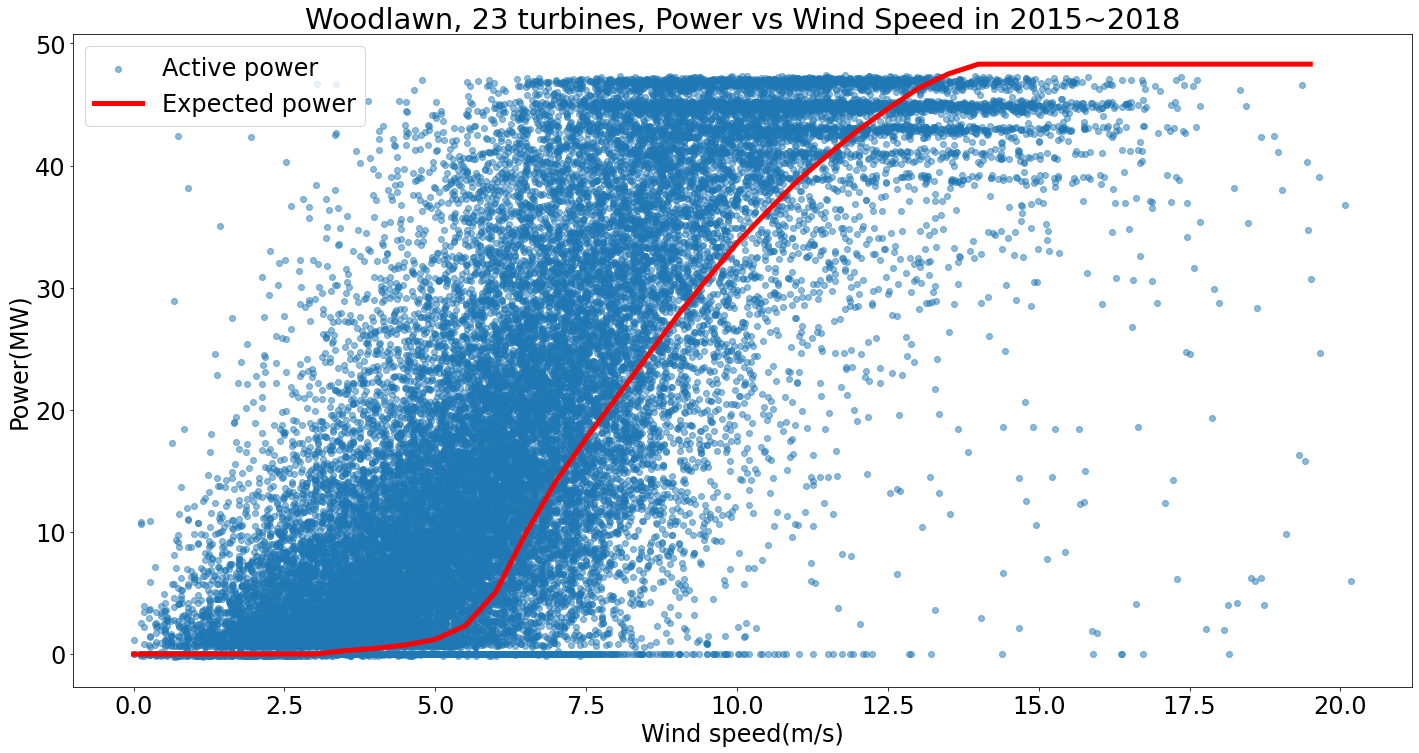

In [49]:
print(f'How many hours in power data? {power.shape[0]}\nHow many hours in velocity data? {vel.shape[1]}')
plt.figure(figsize=(24,12))
plt.scatter(vel[0,:], power,alpha=0.5,label='Active power')

plt.title(WF_name+', 23 turbines, Power vs Wind Speed in 2015~2018')
plt.xlabel('Wind Speed(m/s)')
plt.ylabel('Power(MW)')

pc_vel = np.arange(0,20,0.5)
power_output = np.zeros(pc_vel.shape)
for j in range(pc_vel.shape[0]):
    ws = pc_vel[j]

    power_output[j] = (get_poweroutput(ws, power_curve)*1)/1000*23
plt.plot(pc_vel[:],power_output,'r',linewidth=5,label='Expected power')
# plt.title('Woodlawn WF turbines power curve')
plt.xlabel('Wind speed(m/s)')
plt.ylabel('Power(MW)')
plt.legend()




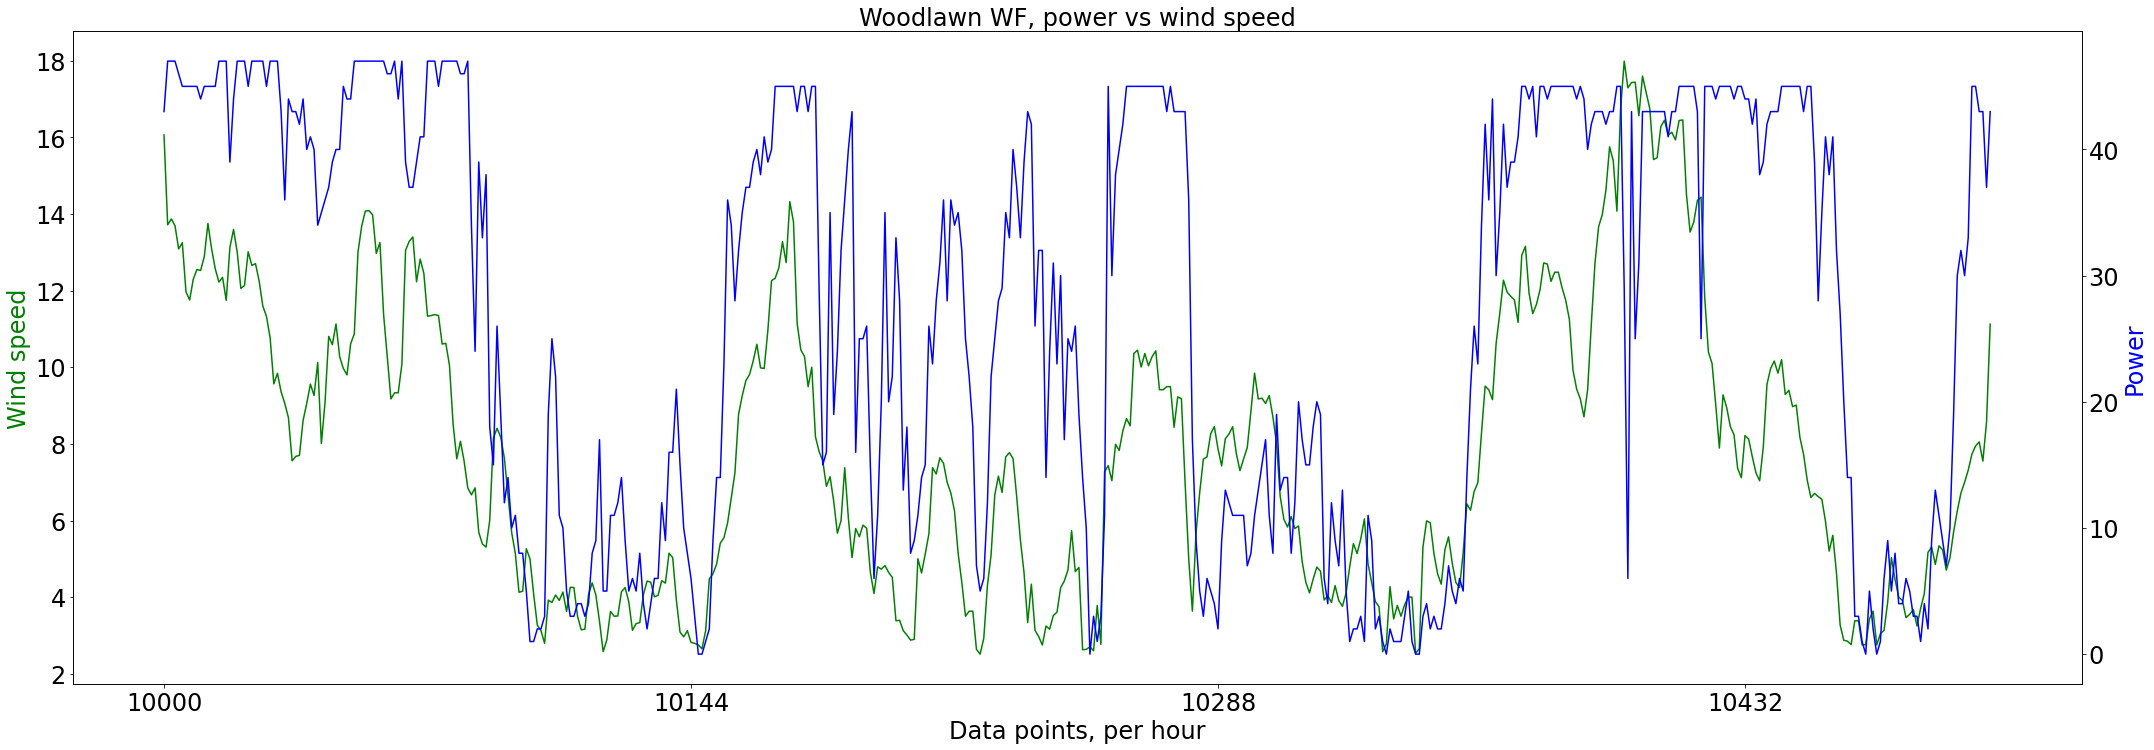

In [229]:
x = np.arange(10000,10500,1)


fig, ax1 = plt.subplots(figsize=(36,12))

ax2 = ax1.twinx()
ax1.plot(x, vel4[10000:10500], 'g-')
ax2.plot(x, power4[10000:10500], 'b-')

plt.title(WF_name+' WF, power vs wind speed', fontsize = 24)
ax1.set_xlabel('Data points, per hour', fontsize = 24)
ax1.set_ylabel('Wind speed', color='g', fontsize = 24)
ax2.set_ylabel('Power', color='b', fontsize = 24)
ax1.set_xticks(np.arange(10000,10500, 144))

clear_output(True)
plt.show()
# fig.savefig(fname='./output')

In [128]:
dataset = np.savez('/FYP/Wind farm/'+WF_name+'/'+WF_name+'_trainset_'+year[0]+'_2018.npz', 
                power=power,
                power_label=power3,
                vel=vel,
                vel_grad=vel_grad,
                ucmp=ucmp,
                u_grad = u_grad,
                vcmp=vcmp,
                v_grad=v_grad,
                attack_ang_deg = attack_ang_deg,
                attack_ang_rad=attack_ang_rad,
                attack_ang_rad_grad = attack_ang_rad_grad  
                )

# Create Validation dataset 2019

In [129]:

year = ['2019']

dir = '/FYP/Wind farm/'+WF_name+'/2019/2019_01ucmp_vcmp.npz'

file = np.load(dir)

u = file['wnd_ucmp']
# ucmp = np.expand_dims(u, axis=0)

v = file['wnd_vcmp']
# vcmp = np.expand_dims(v, axis=0)
for y in year:
    if y =='2019':
        mon = range(2,3)

    for i in mon:
        if i < 10:
            m = '0'+str(i)
        else:
            m = str(i)
        dir = '/FYP/Wind farm/'+WF_name+'/'+str(y)+'/'+str(y)+'_'+m+'ucmp_vcmp.npz'
        # print(dir)
        file = np.load(dir)



        tmp_u = file['wnd_ucmp']
        # u = np.expand_dims(u, axis=0)
        

        tmp_v = file['wnd_vcmp']
        # v = np.expand_dims(v, axis=0)

        # print(tmp_u.shape, tmp_v.shape)
        if tmp_u.shape != tmp_v.shape:
            error('data points mismatched')
            break
        u = np.concatenate((u,tmp_u), axis=1)
        # print(u.shape)
        v = np.concatenate((v,tmp_v), axis=1)

ucmp = u[:,:-10]
vcmp = v[:,:-10]

vel       = np.sqrt(( np.power(ucmp,2)  + np.power(vcmp,2)))


vel_new = np.zeros(vel.shape)

for i in range(vel.shape[0]):
    for j in range(vel.shape[1]):

    # print(vel[i,0,j])
        vel_new[i,j] = mean_speed(vel[i,j])
vel       = np.sqrt(( np.power(ucmp,2)  + np.power(vcmp,2)))


vel_new = np.zeros(vel.shape)

for i in range(vel.shape[0]):
    for j in range(vel.shape[1]):

    # print(vel[i,0,j])
        vel_new[i,j] = mean_speed(vel[i,j])
vel = vel_new
vel_grad  = np.gradient(vel, axis=0) 
u_grad = np.gradient(ucmp, axis=0) 
v_grad = np.gradient(vcmp, axis=0) 

attack_ang_rad = np.arctan2(vcmp,ucmp)
attack_ang_deg = np.arctan2(vcmp,ucmp)* 180 / np.pi

tmp_id = np.where(attack_ang_deg<0)
attack_ang_deg[tmp_id] = attack_ang_deg[tmp_id] + 360

attack_ang_deg_new = np.zeros(attack_ang_deg.shape)
for i in range(vel.shape[0]):
    for j in range(vel.shape[1]):


        attack_ang_deg_new[i,j] = mean_direction(attack_ang_deg[i,j])
attack_ang_deg = attack_ang_deg_new
attack_ang_rad_grad = np.gradient(attack_ang_rad, axis=0) 

csv = '/FYP/Wind farm/'+WF_name+'/'+WF_name+'_2019power.csv'
pw = pd.read_csv(csv).values[120:,1] # offset 10 hours, power starts from midday, 01/01/2015

# power = np.mean(pw.reshape(-1, 12), axis=1) # Get 1 hour averaged data
tmp = []

# get instantaneous data
for i in range(pw.shape[0]):
    if i % 12 == 0:
        tmp.append(pw[i])

power  = np.array(tmp).squeeze()
power = np.int0(power)
mean_p = np.zeros(power.shape)
power_label = np.zeros(power.shape)
for i in range(power.shape[0]):
    mean_p[i] = int(mean_power(power[i]))

    power_label[i] = assign_to_label(mean_p[i])

In [130]:
#Remove the data that wind speed is smaller than 3.5 and bigger than 25
#We do that because according to turbine power curve turbine works between these values.
vel1 = vel.copy()
vel1 = vel1[0,:]
working_data_indx = np.where((vel1>2.5) & (vel1<=25))[0]
vel2 = vel1[working_data_indx]
power2= power_label[working_data_indx] 

p_0 = np.where(power2==0)[0]
vel_0 = np.where(vel2[p_0]>3.5)[0]

vel3=vel2[((power2!=0)&(vel2>3)) | (vel2<3)]
power3 = power2[((power2!=0)&(vel2>3)) | (vel2<3)]

In [131]:
ucmp1 = ucmp[0,:].copy()
ucmp2 = ucmp1[working_data_indx]
ucmp3 = ucmp2[((power2!=0)&(vel2>3)) | (vel2<3)]

vcmp1 = vcmp[0,:].copy()
vcmp2 = vcmp1[working_data_indx]
vcmp3 = vcmp2[((power2!=0)&(vel2>3)) | (vel2<3)]

attack_ang_deg = np.arctan2(vcmp3,ucmp3)* 180 / np.pi

tmp_id = np.where(attack_ang_deg<0)
attack_ang_deg[tmp_id] = attack_ang_deg[tmp_id] + 360

attack_ang_deg_new = np.zeros(attack_ang_deg.shape)
for i in range(vel3.shape[0]):
        attack_ang_deg_new[i] = mean_direction(attack_ang_deg[i])

attack_ang_deg = attack_ang_deg_new

How many hours in power data? 976
How many hours in velocity data? 1406


Text(0, 0.5, 'power')

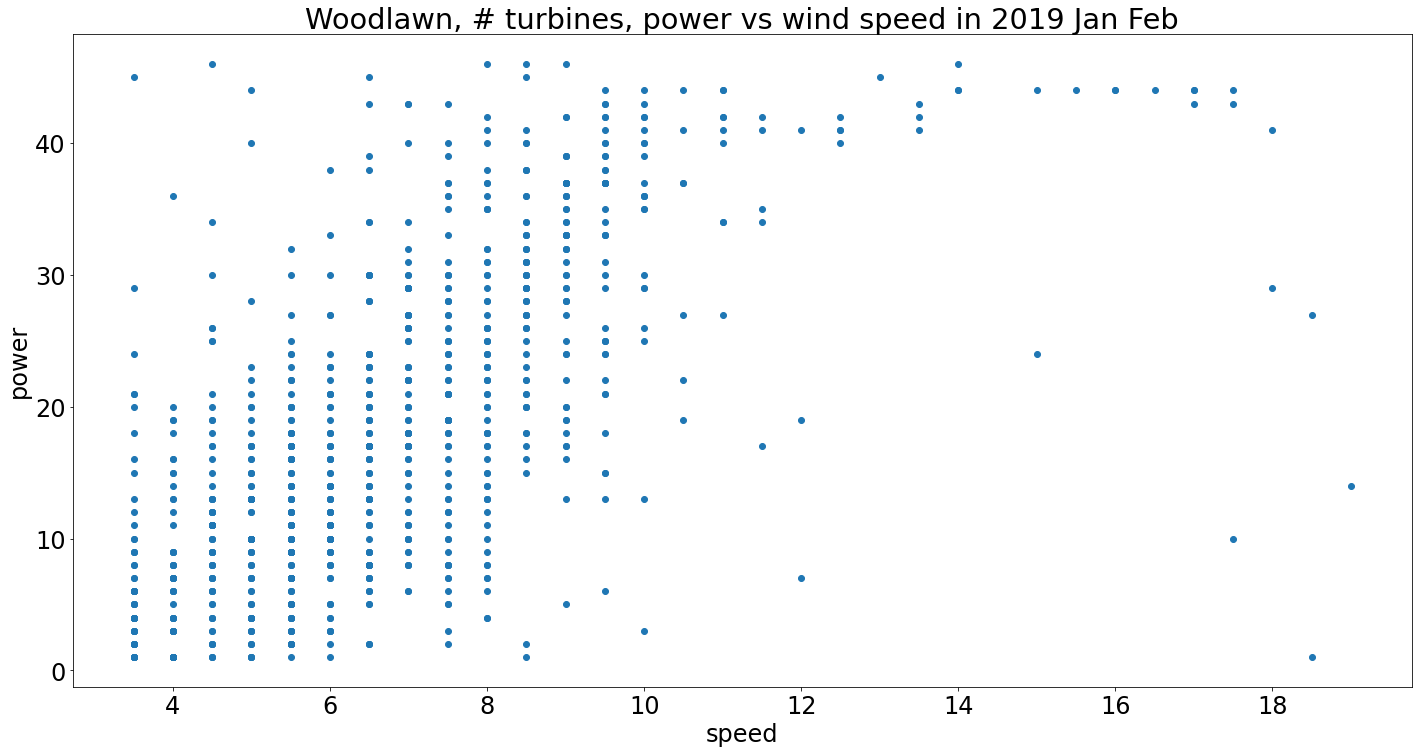

In [132]:
vel = vel3.copy()
power = power3.copy()
print(f'How many hours in power data? {power.shape[0]}\nHow many hours in velocity data? {ucmp.shape[1]}')

plt.figure(figsize=(24,12))
plt.scatter(vel[:], power[:])

plt.title(WF_name+', # turbines, power vs wind speed in 2019 Jan Feb')
plt.xlabel('speed')
plt.ylabel('power')


In [133]:
(power.shape[0])/2

488.0

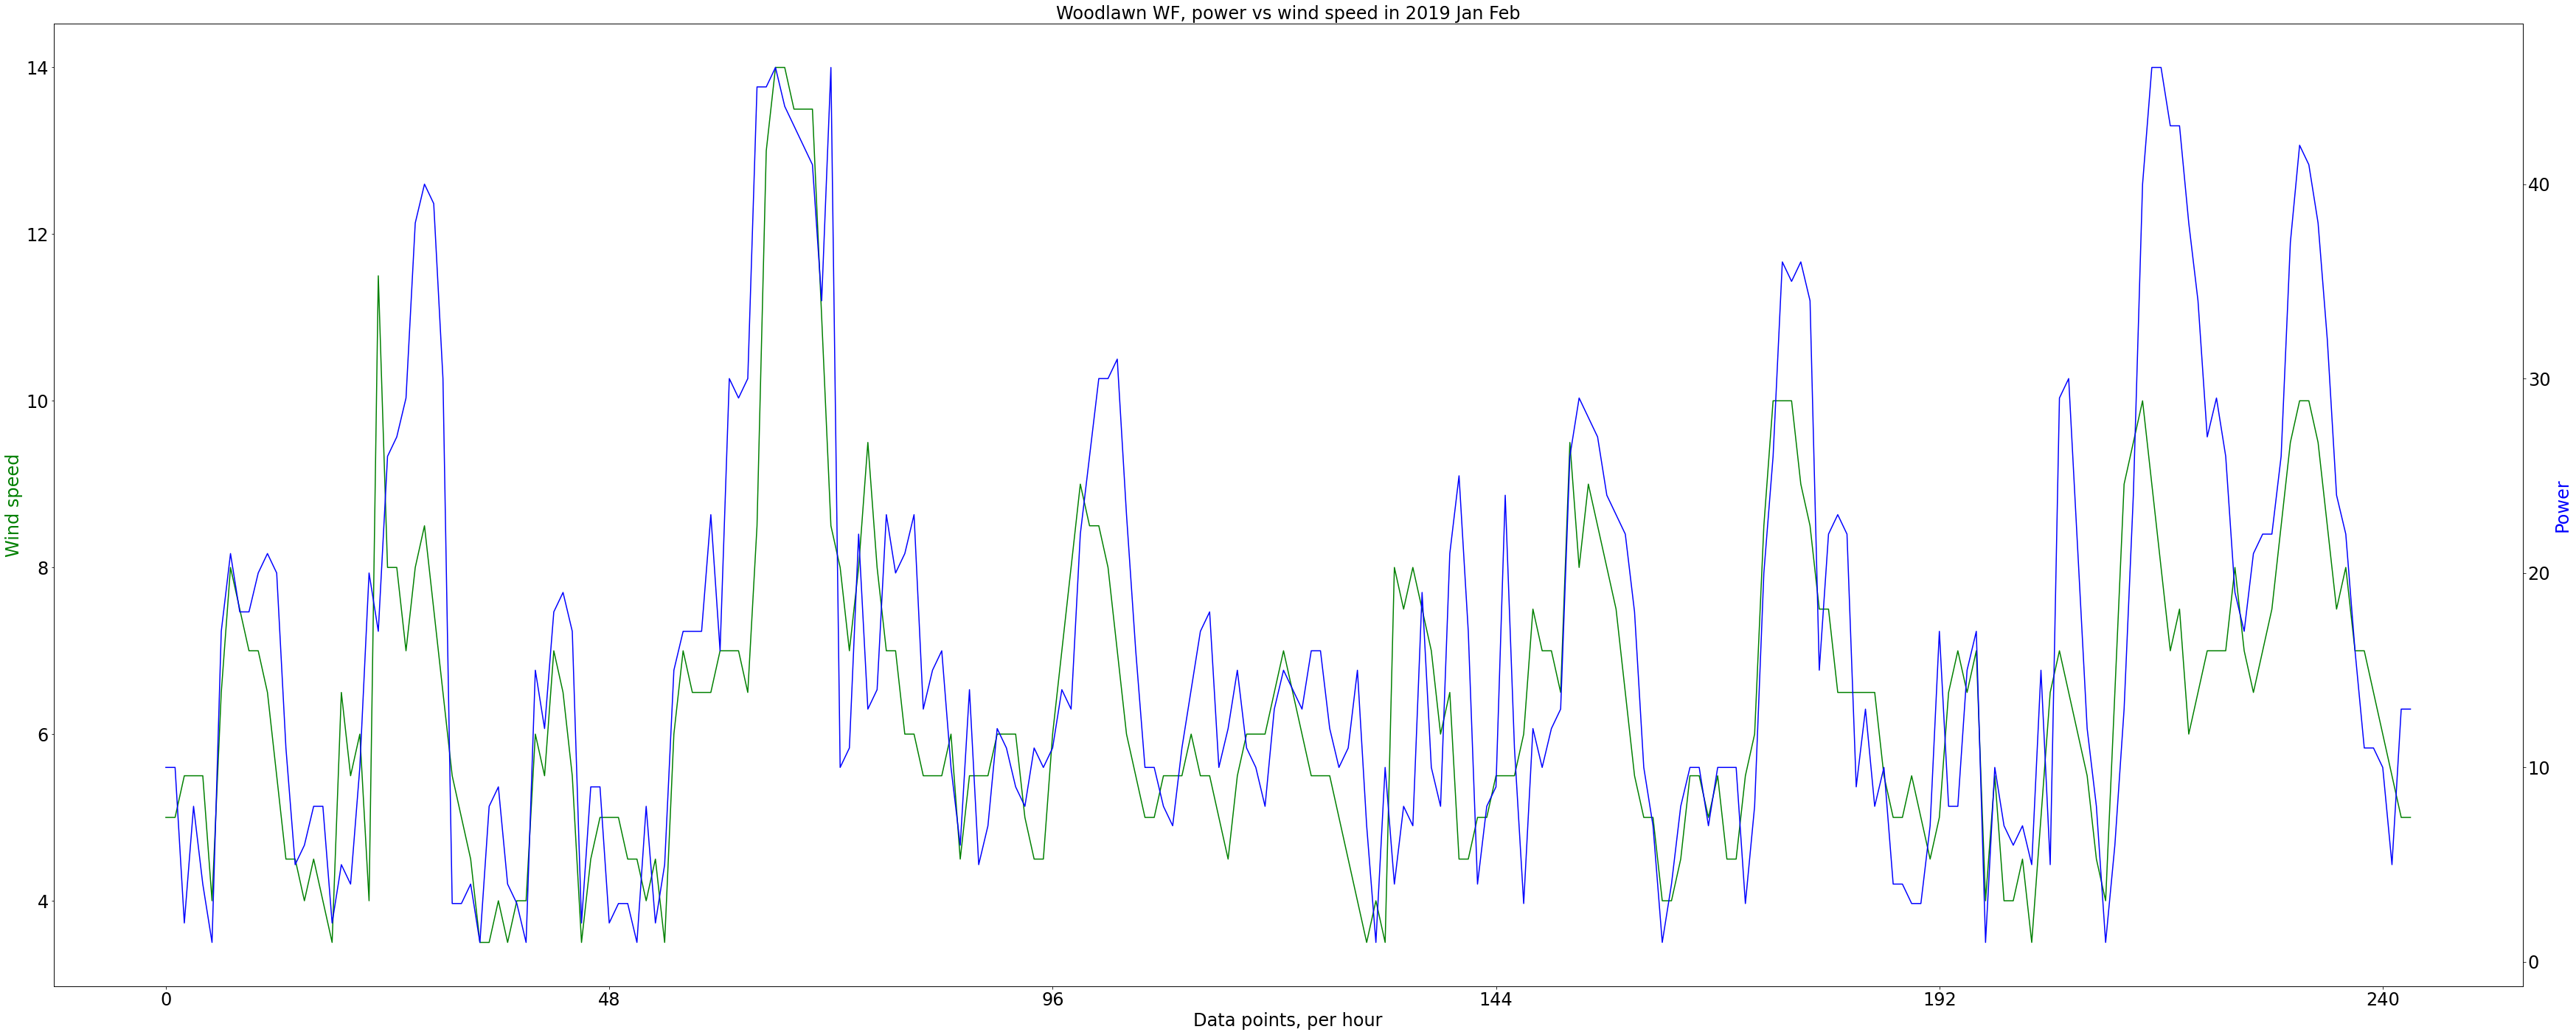

In [134]:
num_data = int((power.shape[0])/4)

x = np.arange(0,num_data,1)


fig, ax1 = plt.subplots(figsize=(60,24))

ax2 = ax1.twinx()
ax1.plot(x, vel[:num_data], 'g-')
ax2.plot(x, power[:num_data], 'b-')

plt.title(WF_name+' WF, power vs wind speed in 2019 Jan Feb', fontsize = 24)
ax1.set_xlabel('Data points, per hour', fontsize = 24)
ax1.set_ylabel('Wind speed', color='g', fontsize = 24)
ax2.set_ylabel('Power', color='b', fontsize = 24)
ax1.set_xticks(np.arange(0,num_data, 48))
clear_output(True)
plt.show()
# fig.savefig(fname='./output')

In [135]:
dataset = np.savez('/FYP/Wind farm/'+WF_name+'/'+WF_name+'_vldset_2019.npz', 
                power_label=power3,
                vel=vel,
                vel_grad=vel_grad,
                ucmp=ucmp,
                u_grad = u_grad,
                vcmp=vcmp,
                v_grad=v_grad,
                attack_ang_deg = attack_ang_deg,
                attack_ang_rad=attack_ang_rad,
                attack_ang_rad_grad = attack_ang_rad_grad  
                )

In [ ]:
attack_ang_deg[0,:1000]

array([  0.,   0.,   0.,   0.,   0.,  30.,  30., 150., 180., 180., 180.,
       180., 180., 180., 180., 210., 180., 180., 180., 180., 180., 210.,
       270., 300., 330., 330., 330., 330., 330., 330., 180., 180., 180.,
       180., 180., 180., 180., 180., 150., 180., 180., 180., 180., 180.,
       180., 180., 180., 210., 210., 240., 300., 300., 270., 270., 270.,
       270., 240., 240., 210., 210., 210., 210., 210., 210., 210., 210.,
       240.,   0.,  60., 330., 300., 330., 330., 330., 330., 330., 330.,
       330., 330.,   0.,   0.,   0., 300., 270., 270., 270., 300., 330.,
       300., 330., 330., 330., 330., 300., 330., 330., 330., 330., 330.,
         0.,   0., 150., 150., 180., 180., 150., 150., 150., 150., 150.,
       150., 150., 150., 150., 150., 150., 150., 150., 150., 180., 180.,
       180., 180., 180., 180., 180., 180., 180., 180., 180., 180., 180.,
       180., 150., 150., 150., 150., 180., 180., 180., 180., 180., 210.,
       210., 210., 210., 210., 210., 210., 210., 21

In [ ]:
np.unique(power_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46.])

# UDF

In [ ]:

for i in range(12,24):
    # For each turbine:
    F0 = '"F'+ '0_'+str(i)+'"	"'+'IF(wt'+str(i)+'_monitor>3[m/s],'+'F1_'+str(i)+',0[Pa])"	""	#f	#f'
    F1 = '"F'+ '1_'+str(i)+'"	"'+'IF(wt'+str(i)+'_monitor<4[m/s],'+'V1_'+str(i)+',F2_'+str(i)+')"	""	#f	#f'
    F2 = '"F'+ '2_'+str(i)+'"	"'+'IF(wt'+str(i)+'_monitor>=4[m/s],'+'F3_'+str(i)+',0[Pa])"	""	#f	#f'
    F3 = '"F'+ '3_'+str(i)+'"	"'+'IF(wt'+str(i)+'_monitor<=12[m/s],V2_'+str(i)+',V3_'+str(i)+')"	""	#f	#f'
    V1 = '"V'+	'1_'+str(i)+'"	"'+'8.14*wt'+str(i)+'_monitor*1[s/m]*1[Pa]-24.43[Pa]"	""	#f	#f'
    V2 = '"V'+	'2_'+str(i)+'"	"'+'-0.09*wt'+str(i)+'_monitor^3*1[s^3/m^3]*1[Pa]+1.66*wt'+str(i)+'_monitor^2*1[s^2/m^2]*1[Pa]-3.92[s/m]*wt'+str(i)+'_monitor*1[Pa]+3.04[Pa]"	""	#f	#f'
    V3 = '"V'+	'3_'+str(i)+'"	"'+'-0.01*wt'+str(i)+'_monitor^3*1[s^3/m^3]*1[Pa]+0.69*wt'+str(i)+'_monitor^2*1[s^2/m^2]*1[Pa]-16.39[s/m]*wt'+str(i)+'_monitor*1[Pa]+156.11[Pa]"	""	#f	#f'
    # p = '"Power'+str(i)+'"	"0.4*0.5*1.23[kg/m^3]*6082[m^2]*'+'wt'+str(i)+'_monitor'+'^3/1000"	""	#f	#f'
    p = '"Power'+str(i)+'"	"21*tanh(0.18*wt'+str(i)+'_monitor*1[s/m])^(3*e)/10*1000 * 1[kg m^2 s^-3]"	""	#f	#f'
    momentum = '"momentum'+str(i)+'"	"'+'F0_'+str(i)+'/3[m]"	""	#f	#f'
    wt = '"wt'+str(i)+'_monitor"'+'	"Average(VelocityMagnitude, [\'wt.'+str(i)+'\''+'], Weight=\'Volume\')"	""	#f	#f'
    print(F0,'\n',F1,'\n',F2,'\n',F3,'\n',V1,'\n',V2,'\n',V3,'\n',momentum,'\n',wt,'\n',p,'\n')


"F0_12"	"IF(wt12_monitor>3[m/s],F1_12,0[Pa])"	""	#f	#f 
 "F1_12"	"IF(wt12_monitor<4[m/s],V1_12,F2_12)"	""	#f	#f 
 "F2_12"	"IF(wt12_monitor>=4[m/s],F3_12,0[Pa])"	""	#f	#f 
 "F3_12"	"IF(wt12_monitor<=12[m/s],V2_12,V3_12)"	""	#f	#f 
 "V1_12"	"8.14*wt12_monitor*1[s/m]*1[Pa]-24.43[Pa]"	""	#f	#f 
 "V2_12"	"-0.09*wt12_monitor^3*1[s^3/m^3]*1[Pa]+1.66*wt12_monitor^2*1[s^2/m^2]*1[Pa]-3.92[s/m]*wt12_monitor*1[Pa]+3.04[Pa]"	""	#f	#f 
 "V3_12"	"-0.01*wt12_monitor^3*1[s^3/m^3]*1[Pa]+0.69*wt12_monitor^2*1[s^2/m^2]*1[Pa]-16.39[s/m]*wt12_monitor*1[Pa]+156.11[Pa]"	""	#f	#f 
 "momentum12"	"F0_12/3[m]"	""	#f	#f 
 "wt12_monitor"	"Average(VelocityMagnitude, ['wt.12'], Weight='Volume')"	""	#f	#f 
 "Power12"	"21*tanh(0.18*wt12_monitor*1[s/m])^(3*e)/10*1000 * 1[kg m^2 s^-3]"	""	#f	#f 

"F0_13"	"IF(wt13_monitor>3[m/s],F1_13,0[Pa])"	""	#f	#f 
 "F1_13"	"IF(wt13_monitor<4[m/s],V1_13,F2_13)"	""	#f	#f 
 "F2_13"	"IF(wt13_monitor>=4[m/s],F3_13,0[Pa])"	""	#f	#f 
 "F3_13"	"IF(wt13_monitor<=12[m/s],V2_13,V3_13)"	""	#f	#f

In [ ]:
WF_name='Taralga'


year = ['2015']

dir = '/FYP/Wind farm/'+WF_name+'/2015/2015_01ucmp_vcmp.npz'

file = np.load(dir)

u = file['wnd_ucmp']
# ucmp = np.expand_dims(u, axis=0)

v = file['wnd_vcmp']
# vcmp = np.expand_dims(v, axis=0)
for y in year:
    mon= range(2,4)
    for i in mon:
        if i < 10:
            m = '0'+str(i)
        else:
            m = str(i)
        dir = '/FYP/Wind farm/'+WF_name+'/'+str(y)+'/'+str(y)+'_'+m+'ucmp_vcmp.npz'
        print(dir)
        file = np.load(dir)



        tmp_u = file['wnd_ucmp']
        # u = np.expand_dims(u, axis=0)
        

        tmp_v = file['wnd_vcmp']
        # v = np.expand_dims(v, axis=0)

        print(tmp_u.shape, tmp_v.shape)
        if tmp_u.shape != tmp_v.shape:
            error('data points mismatched')
            break
        u = np.concatenate((u,tmp_u), axis=1)
        print(u.shape)
        v = np.concatenate((v,tmp_v), axis=1)

ucmp = u[:,:-10]
vcmp = v[:,:-10]
vel = np.sqrt(( np.power(ucmp,2)  + np.power(vcmp,2)))

/FYP/Wind farm/Taralga/2015/2015_02ucmp_vcmp.npz
(9, 672) (9, 672)
(9, 1416)
/FYP/Wind farm/Taralga/2015/2015_03ucmp_vcmp.npz
(9, 744) (9, 744)
(9, 2160)


In [ ]:
csv = '/FYP/Wind farm/'+WF_name+'/'+WF_name+'_2015_test_power.csv'
pw = pd.read_csv(csv).values[120:,1] # offset 10 hours, power starts from midday, 01/01/2015

power = np.mean(pw.reshape(-1, 12), axis=1) # Get 1 hour averaged data
# tmp = []

# # get instantaneous data
# for i in range(pw.shape[0]):
#     if i % 12 == 0:
#         tmp.append(pw[i])

# power  = np.array(tmp).squeeze()
power = np.int0(power)

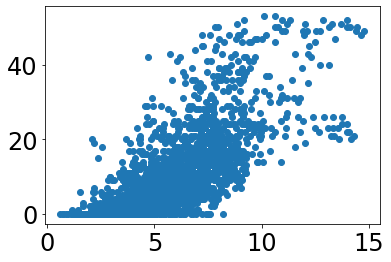

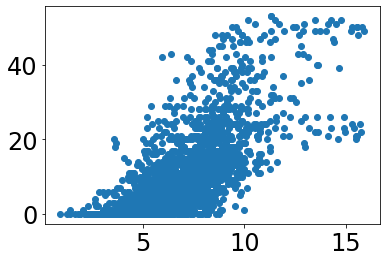

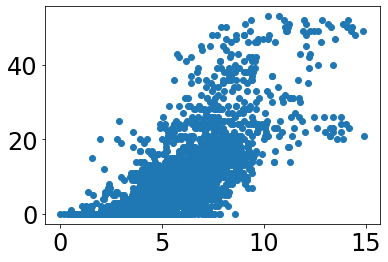

In [ ]:
plt.figure()
plt.scatter(np.mean(vel,axis=0),power)
plt.figure()
plt.scatter(np.max(vel,axis=0),power)
plt.figure()
plt.scatter(vel[0,:],power)

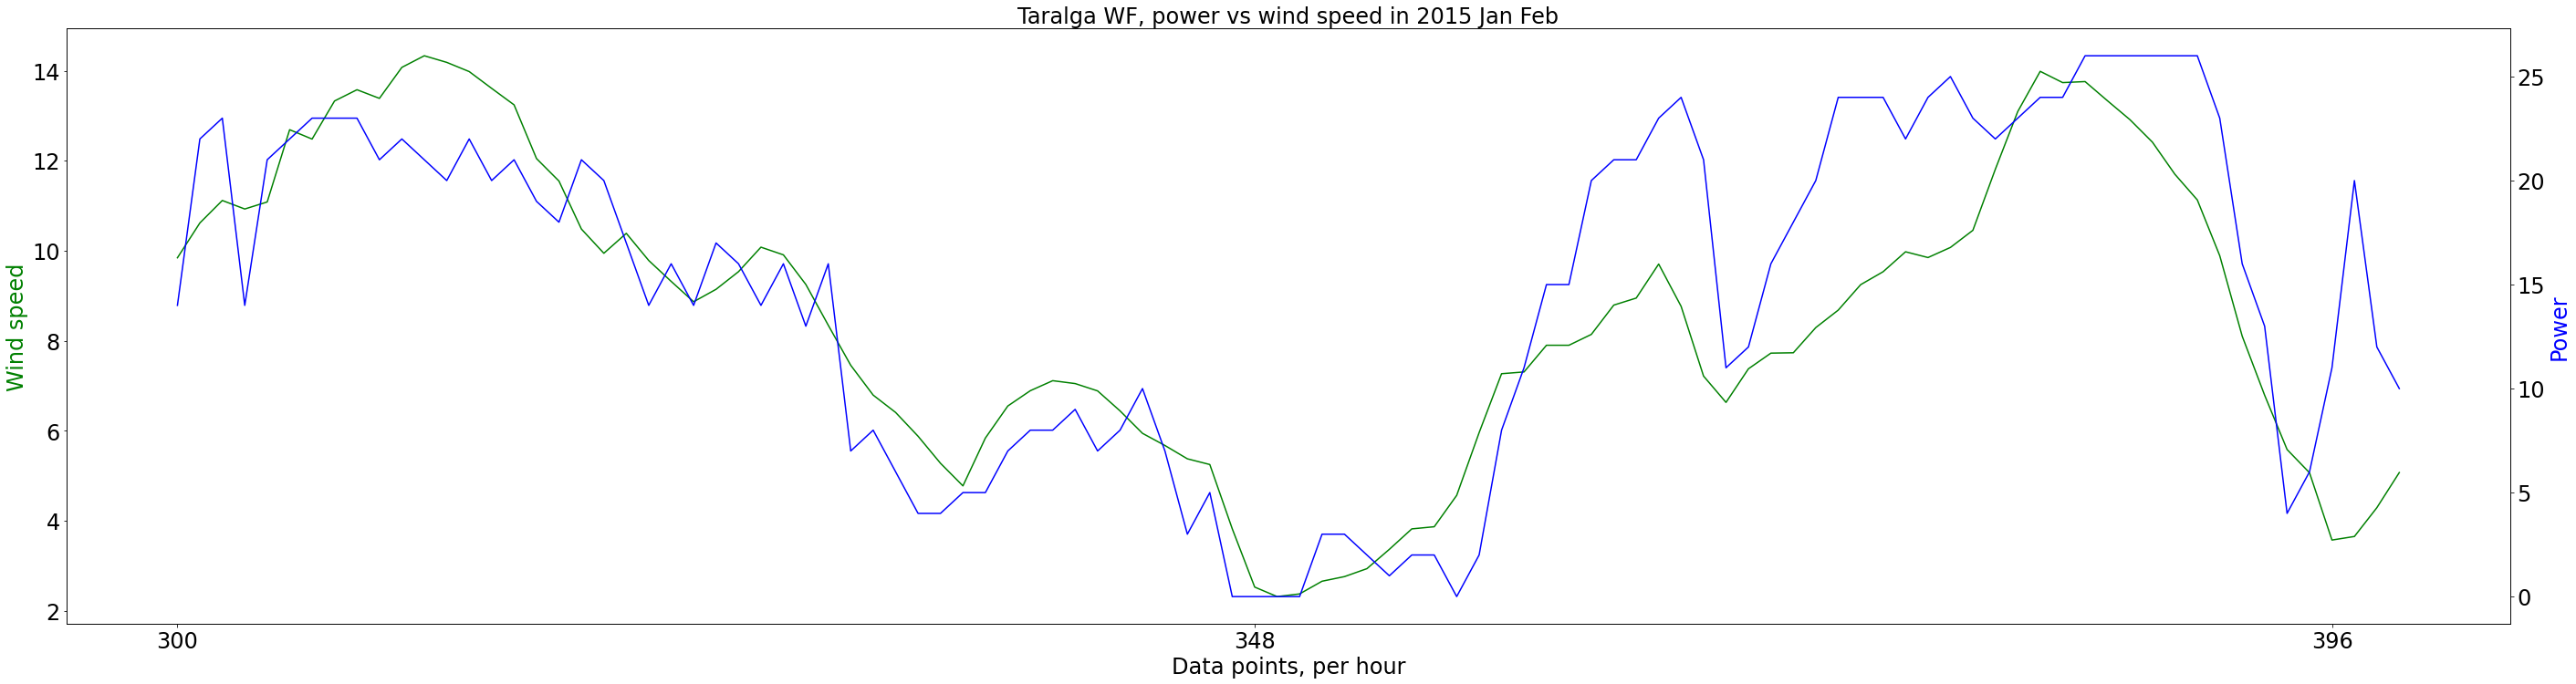

In [ ]:
num_data = 400

x = np.arange(300,num_data,1)


fig, ax1 = plt.subplots(figsize=(48,12))

ax2 = ax1.twinx()
# ax1.plot(x, vel[0,300:num_data], 'g-')
ax1.plot(x, np.mean(vel[:,300:num_data],axis=0), 'g-')
ax2.plot(x, power[300:num_data], 'b-')

plt.title(WF_name+' WF, power vs wind speed in 2015 Jan Feb', fontsize = 24)
ax1.set_xlabel('Data points, per hour', fontsize = 24)
ax1.set_ylabel('Wind speed', color='g', fontsize = 24)
ax2.set_ylabel('Power', color='b', fontsize = 24)
ax1.set_xticks(np.arange(300,num_data, 48))

# fig.savefig(fname='./output')

/FYP/Wind farm/Taralga/2015/2015_02ucmp_vcmp.npz
(9, 672) (9, 672)
(9, 1416)
/FYP/Wind farm/Taralga/2015/2015_03ucmp_vcmp.npz
(9, 744) (9, 744)
(9, 2160)


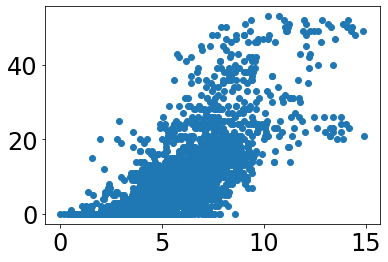

In [ ]:
WF_name='Taralga'


year = ['2015']

dir = '/FYP/Wind farm/'+WF_name+'/2015/2015_01ucmp_vcmp.npz'

file = np.load(dir)

u = file['wnd_ucmp']
# ucmp = np.expand_dims(u, axis=0)

v = file['wnd_vcmp']
# vcmp = np.expand_dims(v, axis=0)
for y in year:
    mon= range(2,4)
    for i in mon:
        if i < 10:
            m = '0'+str(i)
        else:
            m = str(i)
        dir = '/FYP/Wind farm/'+WF_name+'/'+str(y)+'/'+str(y)+'_'+m+'ucmp_vcmp.npz'
        print(dir)
        file = np.load(dir)



        tmp_u = file['wnd_ucmp']
        # u = np.expand_dims(u, axis=0)
        

        tmp_v = file['wnd_vcmp']
        # v = np.expand_dims(v, axis=0)

        print(tmp_u.shape, tmp_v.shape)
        if tmp_u.shape != tmp_v.shape:
            error('data points mismatched')
            break
        u = np.concatenate((u,tmp_u), axis=1)
        print(u.shape)
        v = np.concatenate((v,tmp_v), axis=1)

ucmp = u[:,:-10]
vcmp = v[:,:-10]
vel = np.sqrt(( np.power(ucmp,2)  + np.power(vcmp,2)))

plt.scatter(vel[0,:],power)

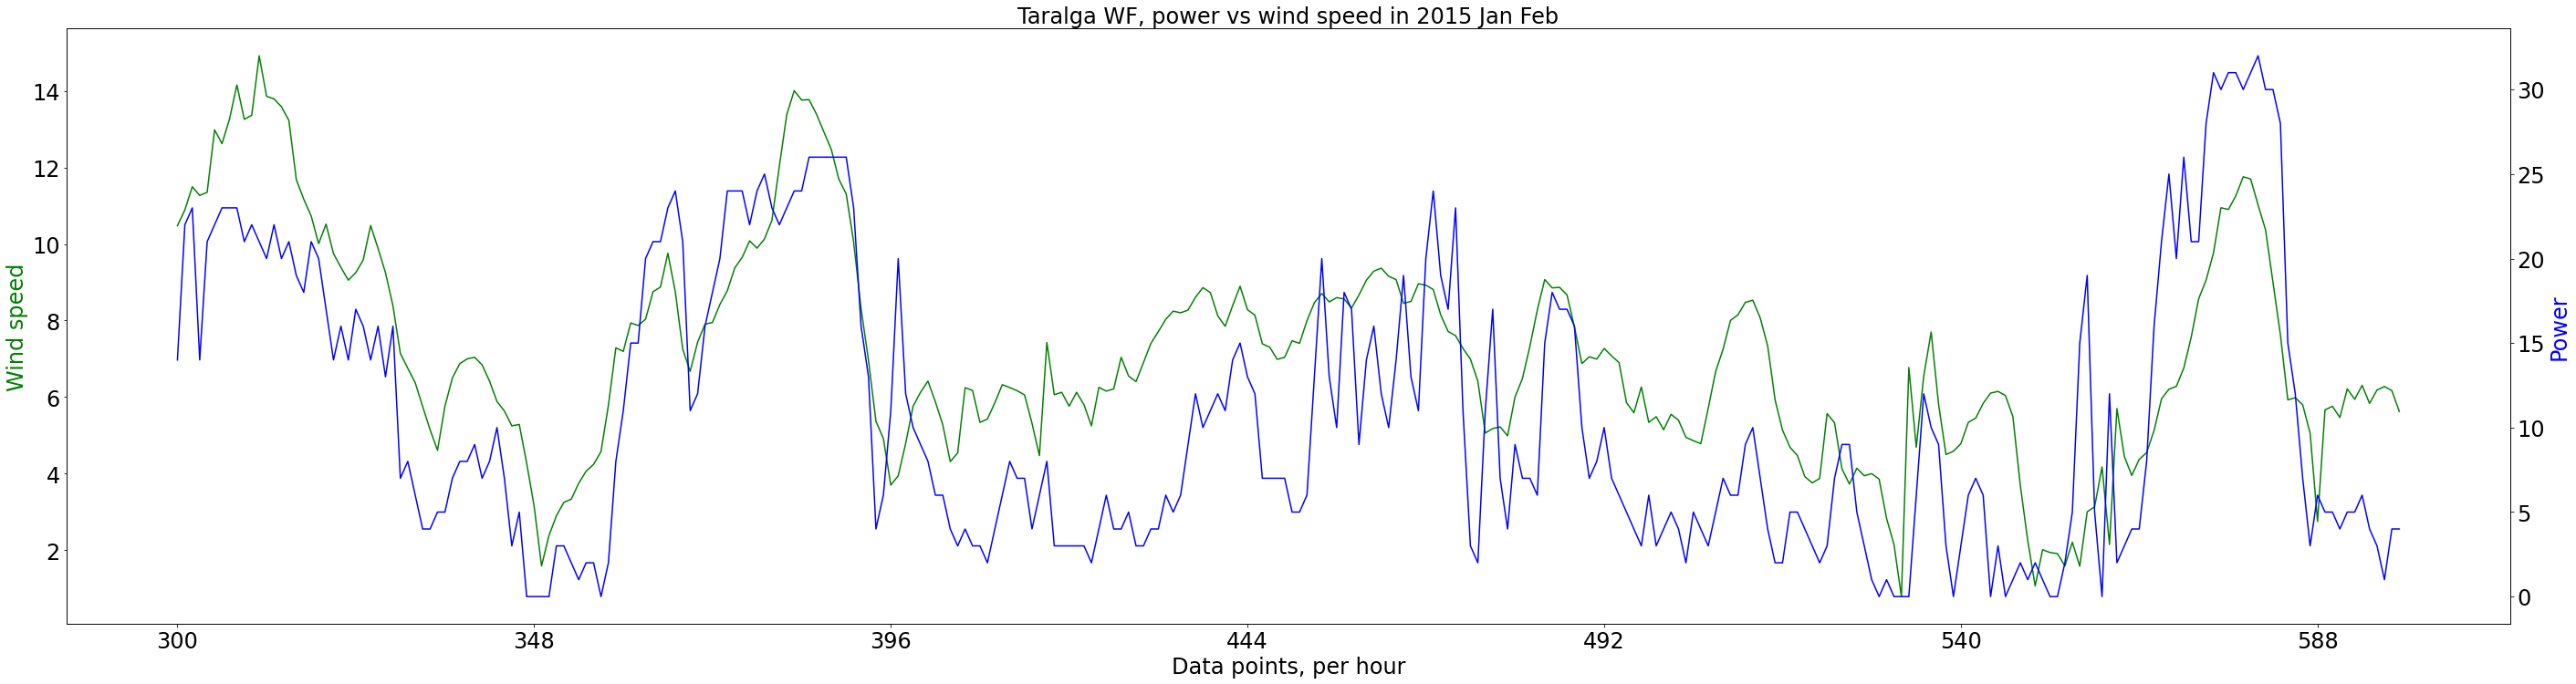

In [ ]:
num_data = 600

x = np.arange(300,num_data,1)


fig, ax1 = plt.subplots(figsize=(48,12))

ax2 = ax1.twinx()
ax1.plot(x, vel[0,300:num_data], 'g-')
ax2.plot(x, power[300:num_data], 'b-')

plt.title(WF_name+' WF, power vs wind speed in 2015 Jan Feb', fontsize = 24)
ax1.set_xlabel('Data points, per hour', fontsize = 24)
ax1.set_ylabel('Wind speed', color='g', fontsize = 24)
ax2.set_ylabel('Power', color='b', fontsize = 24)
ax1.set_xticks(np.arange(300,num_data, 48))

# fig.savefig(fname='./output')